In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras import layers,activations
from tensorflow.keras.datasets import mnist,cifar10

# 数据读取

In [2]:
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# 将像素的值标准化至0到1的区间内。
train_images, test_images = train_images / 255.0, test_images / 255.0

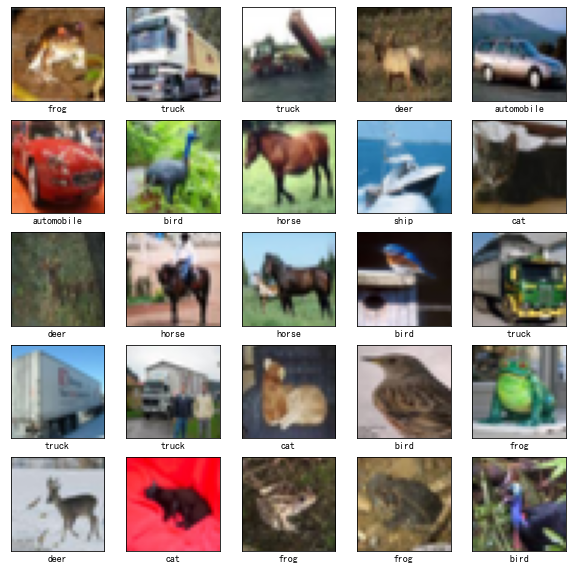

In [3]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    # CIFAR 的标签是 array，需要额外的索引。
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

# 模型构建
## 残差块

In [4]:
class Residual(tf.keras.Model):
    # 定义网络结构
    def __init__(self,num_channels,use_1x1conv=False,strides=1):
        super(Residual,self).__init__()
        # 卷积层
        self.conv1 = layers.Conv2D(num_channels,kernel_size=3,padding="same",strides=strides)
        # 卷积层
        self.conv2 = layers.Conv2D(num_channels,kernel_size=3,padding="same")
        # 是否使用1*1的卷积
        if use_1x1conv:
            self.conv3 = layers.Conv2D(num_channels,kernel_size=1,strides=strides)
        else:
            self.conv3 = None
        # BN层
        self.bn1 = layers.BatchNormalization()
        self.bn2 = layers.BatchNormalization()
    # 定义前向传播过程
    def call(self,x):
        Y = activations.relu(self.bn1(self.conv1(x)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            x = self.conv3(x)
        outputs = activations.relu(Y + x)
        return outputs

## 残差模块

In [5]:
class ResnetBlock(tf.keras.layers.Layer):
    # 定义所需的网络结构
    def __init__(self,num_channels,num_res,first_block=False):
        super(ResnetBlock,self).__init__()
        # 存储残差块
        self.listLayers=[]
        # 遍历残差数目生成模块
        for i in range(num_res):
            # 如果是第一个残差块而且不是第一个模块时
            if i == 0 and not first_block:
                self.listLayers.append(Residual(num_channels,use_1x1conv=True,strides=2))
            else:
                self.listLayers.append(Residual(num_channels))
    # 定义前向传播
    def call(self,X):
        for layers in self.listLayers.layers:
            X = layers(X)
        return X

## 构建resNet网络

In [6]:
class ResNet(tf.keras.Model):
    # 定义网络的构成
    def __init__(self,num_blocks):
        super(ResNet,self).__init__()
        # 输入层
        self.conv = layers.Conv2D(64,kernel_size=3,strides=1,padding="same")
        # BN层
        self.bn = layers.BatchNormalization()
        # 激活层
        self.relu = layers.Activation("relu")
        # 池化层
        self.mp = layers.MaxPool2D(pool_size=2,strides=1,padding="same")
        self.res_block1 = ResnetBlock(64,num_blocks[0],first_block=True)
        self.res_block2 = ResnetBlock(128,num_blocks[1])
        self.res_block3 = ResnetBlock(256,num_blocks[2])
        self.res_block4 = ResnetBlock(512,num_blocks[3])
        # GAP
        self.gap = layers.GlobalAveragePooling2D()
        # 全连接层
        self.fc = layers.Dense(units=10,activation=tf.keras.activations.softmax)
    # 定义前向传播过程
    def call(self,x):
        # 输入部分的传输过程
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.mp(x)
        # block
        x = self.res_block1(x)
        x = self.res_block2(x)
        x = self.res_block3(x)
        x = self.res_block4(x)
        # 输出部分的传输
        x = self.gap(x)
        x = self.fc(x)
        return x

In [18]:
# 实例化
mynet = ResNet([2,2,2,2])
X = tf.random.uniform(shape=(1,32,32,3))
y = mynet(X)
mynet.summary()

Model: "res_net_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           multiple                  1792      
_________________________________________________________________
batch_normalization_17 (Batc multiple                  256       
_________________________________________________________________
activation_1 (Activation)    multiple                  0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0         
_________________________________________________________________
resnet_block_4 (ResnetBlock) multiple                  148736    
_________________________________________________________________
resnet_block_5 (ResnetBlock) multiple                  526976    
_________________________________________________________________
resnet_block_6 (ResnetBlock) multiple                  21

# 模型编译

In [8]:
# 优化器，损失函数，评价指标
mynet.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.005,momentum=0.9),
            loss=tf.keras.losses.sparse_categorical_crossentropy,
            metrics = ["accuracy",tf.keras.metrics.sparse_top_k_categorical_accuracy],loss_weights=[1,0.3,0.3])

# 模型训练

In [9]:
# 模型训练：指定训练数据，batchsize,epoch,验证集
history = mynet.fit(train_images,train_labels,batch_size=100,epochs=100,verbose=1,validation_split=0.1)

Epoch 1/100
450/450 [==============================] - 50s 102ms/step - loss: 1.6243 - accuracy: 0.4205 - sparse_top_k_categorical_accuracy: 0.8757 - val_loss: 1.5159 - val_accuracy: 0.4866 - val_sparse_top_k_categorical_accuracy: 0.9206s - loss: 2.1511 - accuracy: 0.2566 - sparse_top_k_categorical_accuracy: 0.753 - ETA: 36s - loss: 2.1472 - accura - ETA: 30s - loss: 1.9909 - accuracy: 0.3021 - sparse_top_k_catego - ETA: 28s - loss: 1.9448 - accuracy: 0.3161 - sparse_t - ETA: 25s - loss: 1.8873 - accuracy: 0.3339 - sparse_top_k_categorical_accurac - ETA: 24s - loss: 1.8735 - accuracy: 0.3381 - sparse_top_k - E - ETA: 13s - loss: 1.7369 - accuracy: 0.3821 - sparse_top_k_categorical_accuracy: 0.8 - ETA: 13s - loss: 1.7340 - accuracy: 0.3831 - sparse_top_k_cate - ETA: 6s - loss: 1.6709 - accuracy: 0.4044 - s
Epoch 2/100
450/450 [==============================] - 45s 100ms/step - loss: 0.8699 - accuracy: 0.6918 - sparse_top_k_categorical_accuracy: 0.9763 - val_loss: 1.0755 - val_accuracy: 

450/450 [==============================] - 46s 101ms/step - loss: 2.3553e-04 - accuracy: 1.0000 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 0.8832 - val_accuracy: 0.8116 - val_sparse_top_k_categorical_accuracy: 0.9884
Epoch 20/100
450/450 [==============================] - 46s 101ms/step - loss: 2.2825e-04 - accuracy: 1.0000 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 0.8868 - val_accuracy: 0.8128 - val_sparse_top_k_categorical_accuracy: 0.9880
Epoch 21/100
450/450 [==============================] - 46s 102ms/step - loss: 2.1868e-04 - accuracy: 1.0000 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 0.8896 - val_accuracy: 0.8114 - val_sparse_top_k_categorical_accuracy: 0.9886
Epoch 22/100
450/450 [==============================] - 46s 101ms/step - loss: 1.9855e-04 - accuracy: 1.0000 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 0.8916 - val_accuracy: 0.8124 - val_sparse_top_k_categorical_accuracy: 0.9884
Epoch 23/100
450/450 [===================

450/450 [==============================] - 46s 103ms/step - loss: 6.9457e-05 - accuracy: 1.0000 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 0.9370 - val_accuracy: 0.8128 - val_sparse_top_k_categorical_accuracy: 0.9884
Epoch 51/100
450/450 [==============================] - 46s 103ms/step - loss: 6.4709e-05 - accuracy: 1.0000 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 0.9358 - val_accuracy: 0.8118 - val_sparse_top_k_categorical_accuracy: 0.9884.0000 - sparse_top_k_categorical_accura
Epoch 52/100
450/450 [==============================] - 46s 102ms/step - loss: 6.7473e-05 - accuracy: 1.0000 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 0.9387 - val_accuracy: 0.8136 - val_sparse_top_k_categorical_accuracy: 0.9878
Epoch 53/100
450/450 [==============================] - 46s 103ms/step - loss: 6.8170e-05 - accuracy: 1.0000 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 0.9374 - val_accuracy: 0.8136 - val_sparse_top_k_categorical_accuracy: 0.9880s: 

450/450 [==============================] - 47s 104ms/step - loss: 4.4016e-05 - accuracy: 1.0000 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 0.9563 - val_accuracy: 0.8130 - val_sparse_top_k_categorical_accuracy: 0.9884
Epoch 76/100
450/450 [==============================] - 47s 104ms/step - loss: 4.2217e-05 - accuracy: 1.0000 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 0.9568 - val_accuracy: 0.8128 - val_sparse_top_k_categorical_accuracy: 0.9882acy: 1.0000 - sparse_top_k_categoric - ETA: 19s - loss: 4.1595e-05 -  - ETA: 1 - ETA: 7s - loss: 4.1924e-05 
Epoch 77/100
450/450 [==============================] - 46s 102ms/step - loss: 4.5135e-05 - accuracy: 1.0000 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 0.9581 - val_accuracy: 0.8110 - val_sparse_top_k_categorical_accuracy: 0.9880
Epoch 78/100
450/450 [==============================] - 45s 101ms/step - loss: 4.5201e-05 - accuracy: 1.0000 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 0.9589 - va

# 模型评估

In [10]:
mynet.evaluate(test_images,test_labels,verbose=1)

313/313 [==============================] - 5s 15ms/step - loss: 0.9799 - accuracy: 0.8123 - sparse_top_k_categorical_accuracy: 0.9864


[0.9798563718795776, 0.8123000264167786, 0.9864000082015991]

In [11]:
history.history

{'loss': [1.321638584136963,
  0.8387988805770874,
  0.6049849987030029,
  0.406261146068573,
  0.2518948018550873,
  0.15151040256023407,
  0.08516234159469604,
  0.04965497925877571,
  0.03393154963850975,
  0.023754308000206947,
  0.010448748245835304,
  0.003167521208524704,
  0.001114118960686028,
  0.0005993922823108733,
  0.00045135393156670034,
  0.00038143311394378543,
  0.0003140412154607475,
  0.0003009416104760021,
  0.0002464135177433491,
  0.00022528646513819695,
  0.00021797034423798323,
  0.0001962874666787684,
  0.00018820579862222075,
  0.00018612454005051404,
  0.000154149325680919,
  0.00015544357302132994,
  0.00014243280747905374,
  0.00014258593728300184,
  0.0001315647823503241,
  0.00012372936180327088,
  0.00012556284491438419,
  0.00011641537275863811,
  0.00011334420560160652,
  0.00010830742394318804,
  0.00010590776946628466,
  0.00010558805661275983,
  0.00010031006968347356,
  9.435164247406647e-05,
  9.211341239279136e-05,
  8.585427713114768e-05,
  8.5

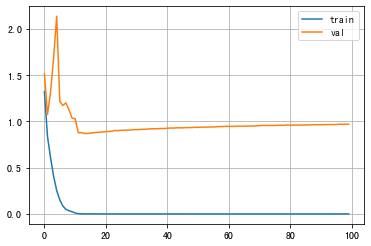

In [12]:
# 损失函数绘制
plt.figure()
plt.plot(history.history["loss"],label="train")
plt.plot(history.history["val_loss"],label="val")
plt.legend()
plt.grid()

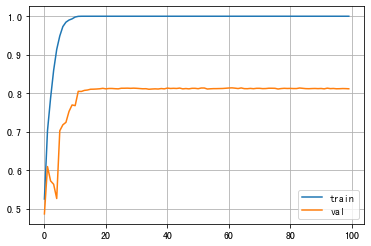

In [13]:
# top1准确率
plt.figure()
plt.plot(history.history["accuracy"],label="train")
plt.plot(history.history["val_accuracy"],label="val")
plt.legend()
plt.grid()

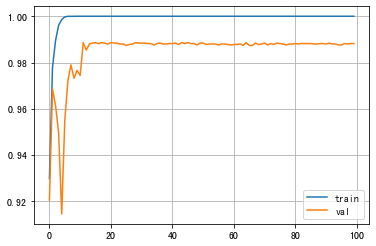

In [14]:
# top5准确率
plt.figure()
plt.plot(history.history["sparse_top_k_categorical_accuracy"],label="train")
plt.plot(history.history["val_sparse_top_k_categorical_accuracy"],label="val")
plt.legend()
plt.grid()

# 预测

下面的图预测结结果是 ship


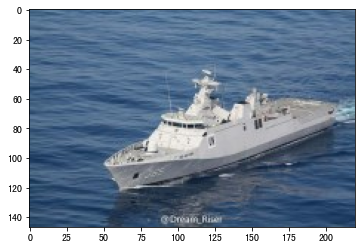

In [15]:
image = Image.open("./img/ship.jpg")
plt.imshow(image)
newpic = np.array(image.resize((32, 32)))/255
print("下面的图预测结结果是",class_names[mynet.predict(np.array([newpic])).argmax()])

下面的图预测结结果是 bird


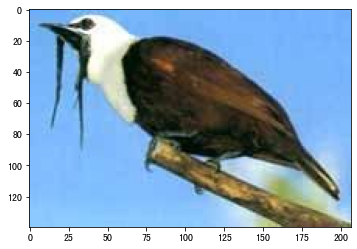

In [16]:
image = Image.open("./img/bird.jpg")
plt.imshow(image)
newpic = np.array(image.resize((32, 32)))/255
print("下面的图预测结结果是",class_names[mynet.predict(np.array([newpic])).argmax()])